Latent Manifold Curvature for Transition Detection

[Step 1] Loading Data...
Features: ['alx', 'aly', 'alz', 'glx', 'gly', 'glz']
Train samples: 291841 | Test samples: 235009

[Step 2] Creating Training Windows...
Train Windows: (5834, 100, 6)

[Step 3] Training Manifold Encoder...

[Training Manifold Encoder]
Epoch 5/30 | Loss: 1.0014 | Recon: 1.0014 | Smooth: 0.0000
Epoch 10/30 | Loss: 0.9951 | Recon: 0.9951 | Smooth: 0.0000
Epoch 15/30 | Loss: 1.0007 | Recon: 1.0007 | Smooth: 0.0000
Epoch 20/30 | Loss: 1.0019 | Recon: 1.0019 | Smooth: 0.0000
Epoch 25/30 | Loss: 1.0033 | Recon: 1.0032 | Smooth: 0.0001
Epoch 30/30 | Loss: 0.9982 | Recon: 0.9982 | Smooth: 0.0000

[Step 4] Detecting Transitions via Manifold Geometry...
Subject 2 | Activity 4 | Detected Transitions: 7


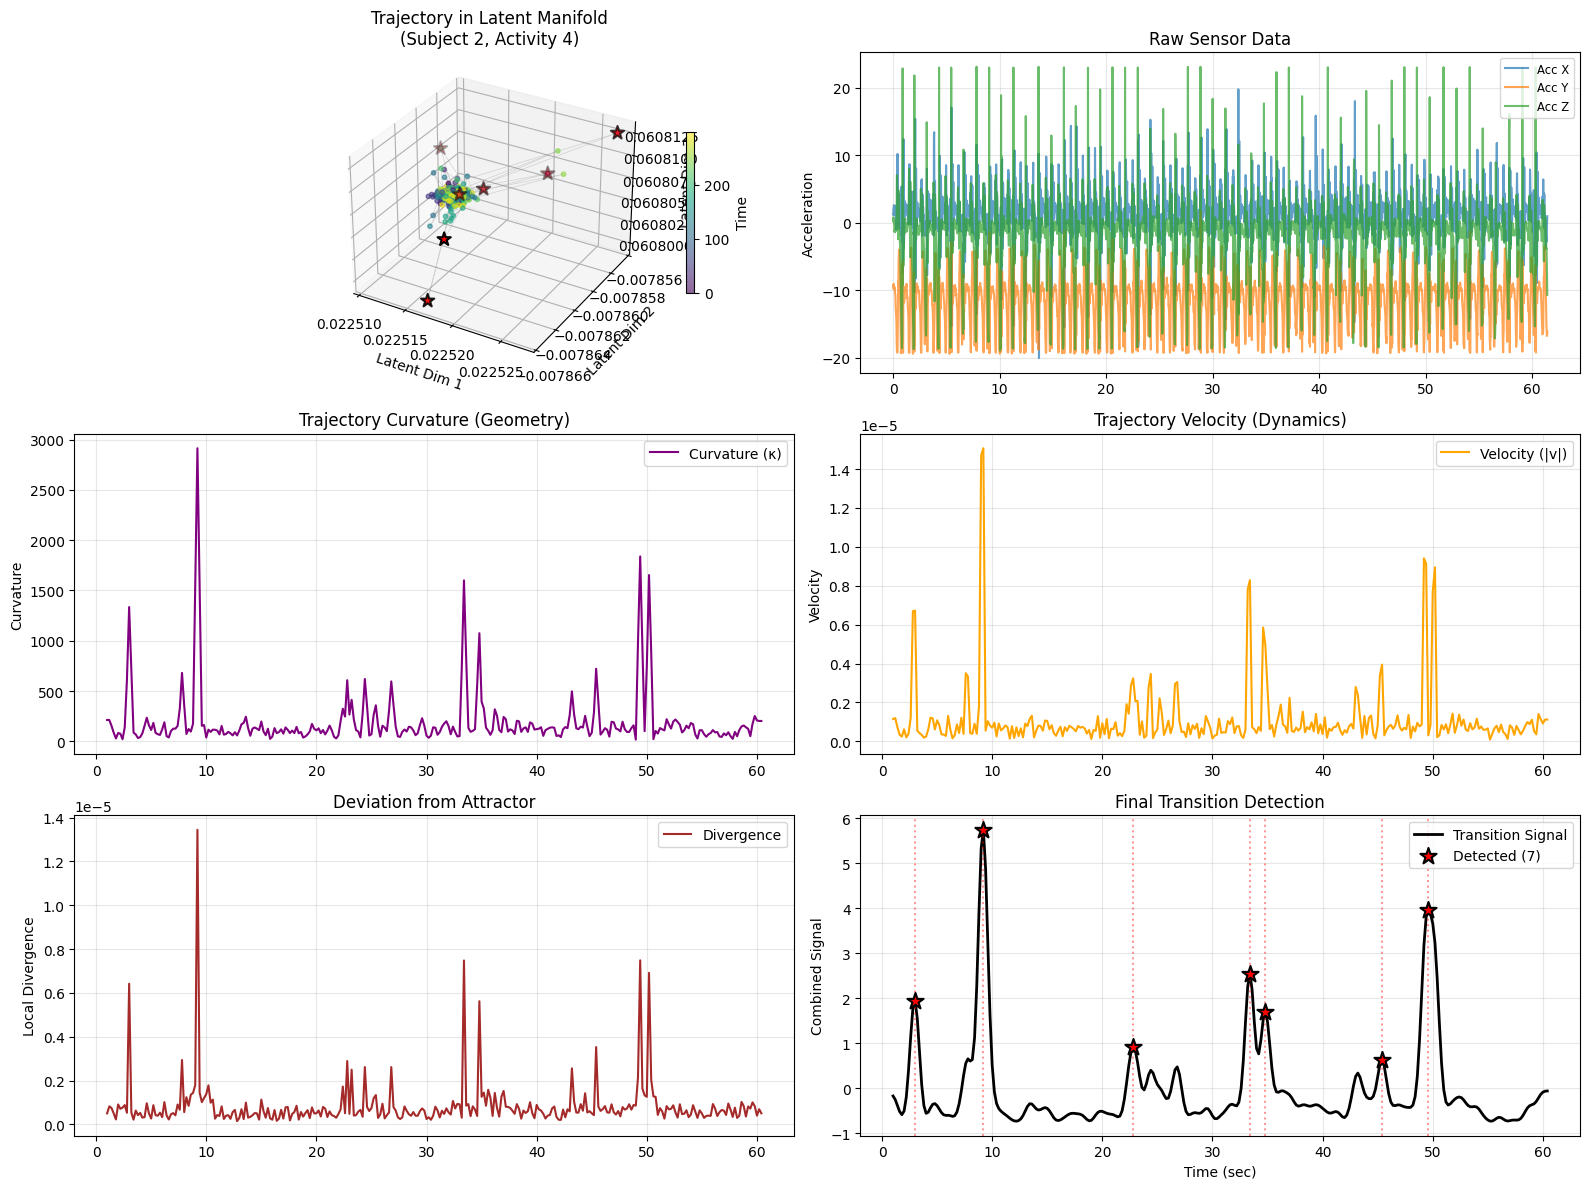

Subject 2 | Activity 6 | Detected Transitions: 10


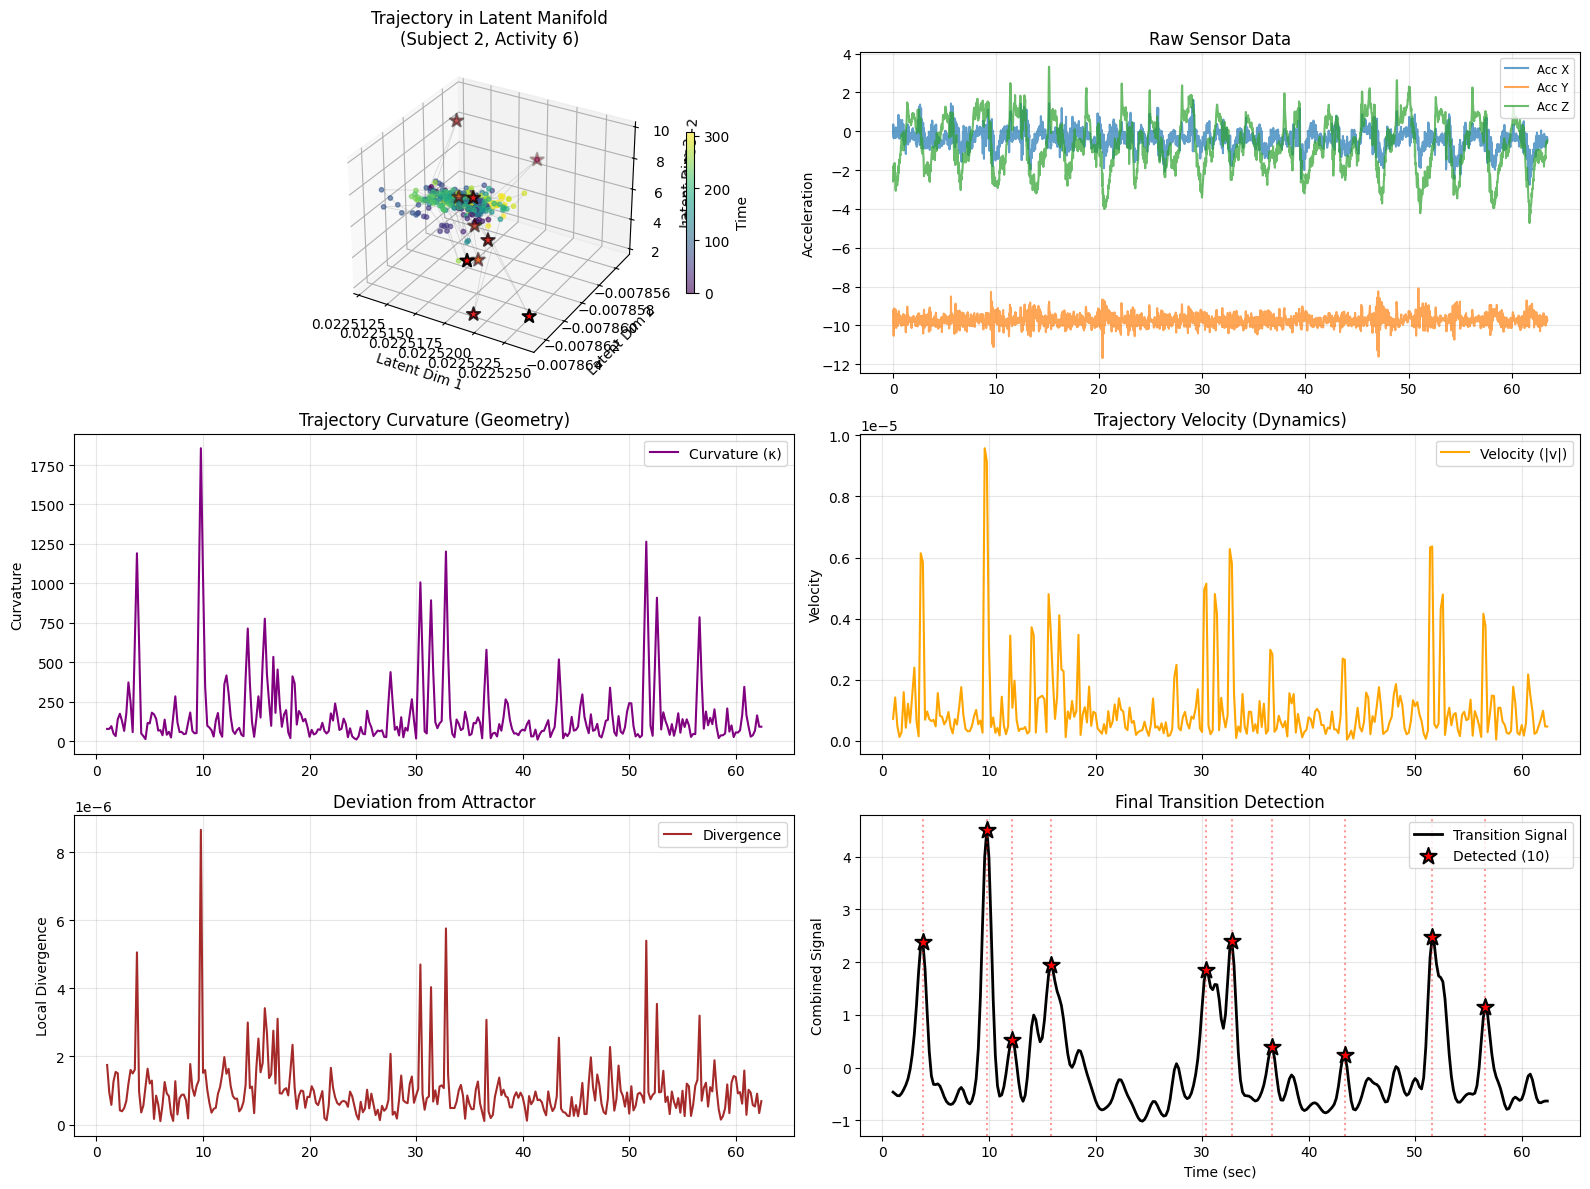

Subject 2 | Activity 7 | Detected Transitions: 9


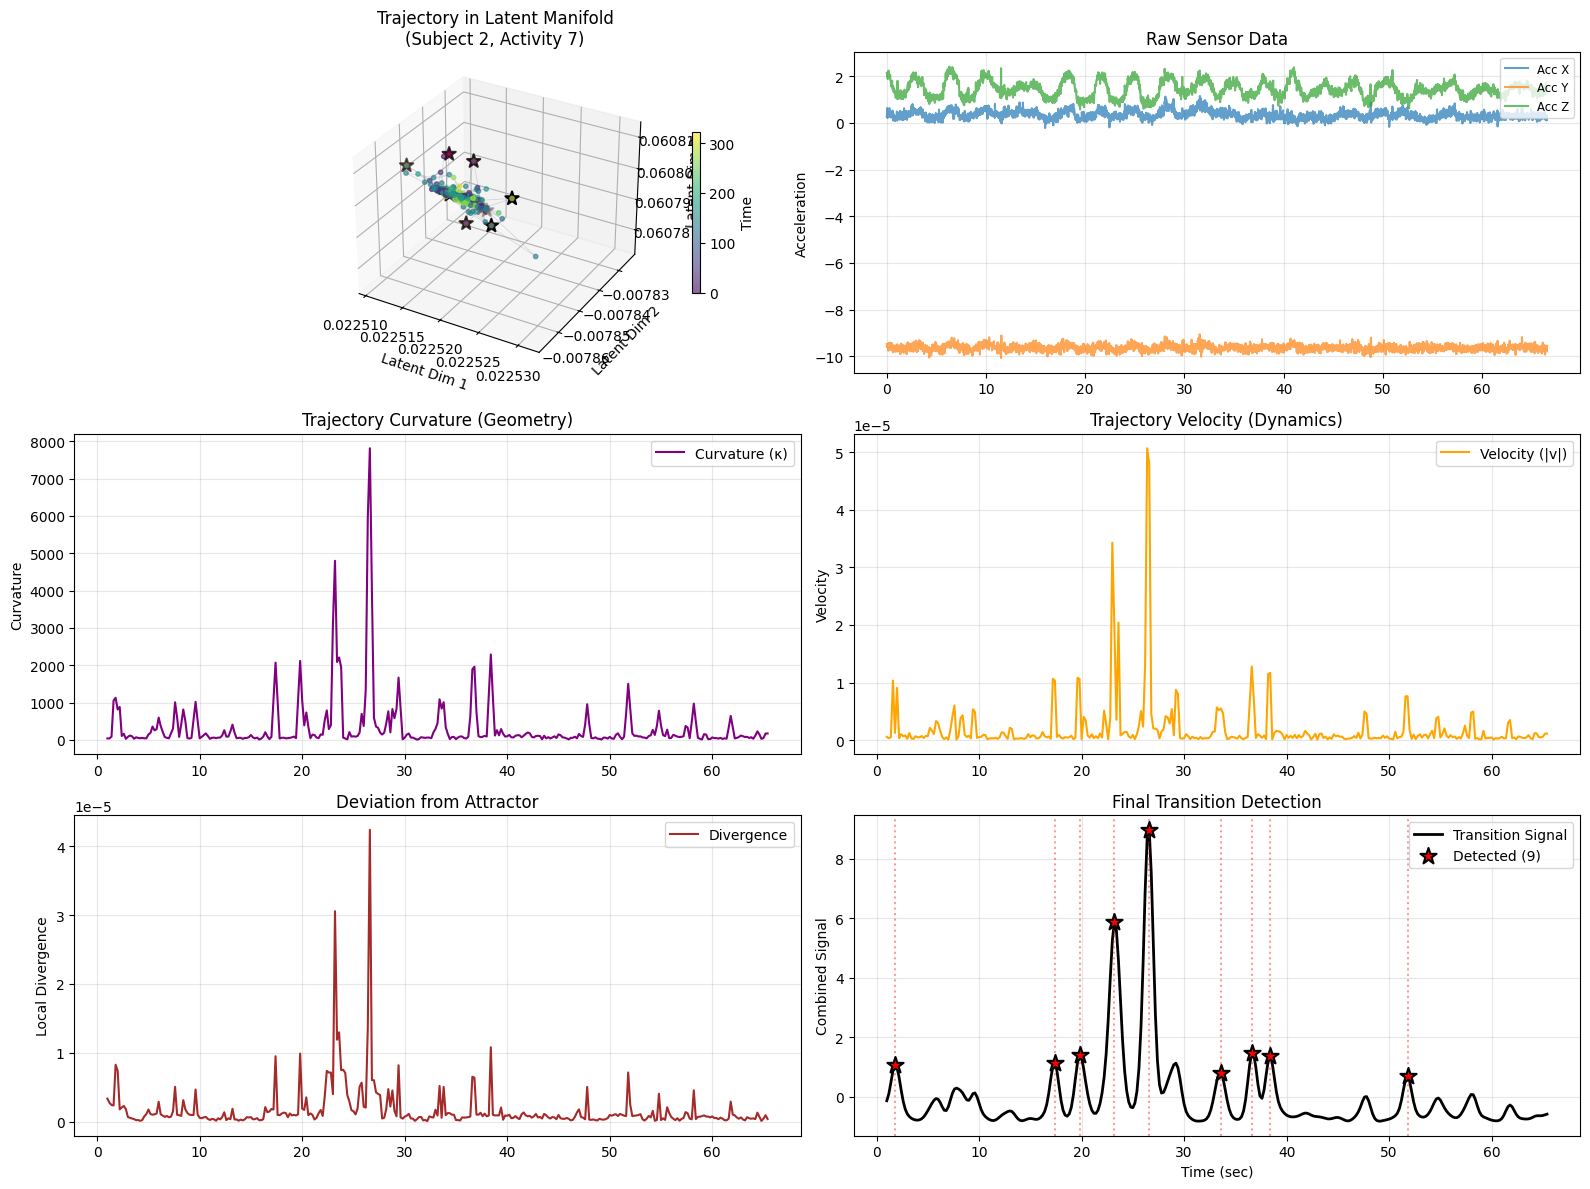

Subject 2 | Activity 8 | Detected Transitions: 16


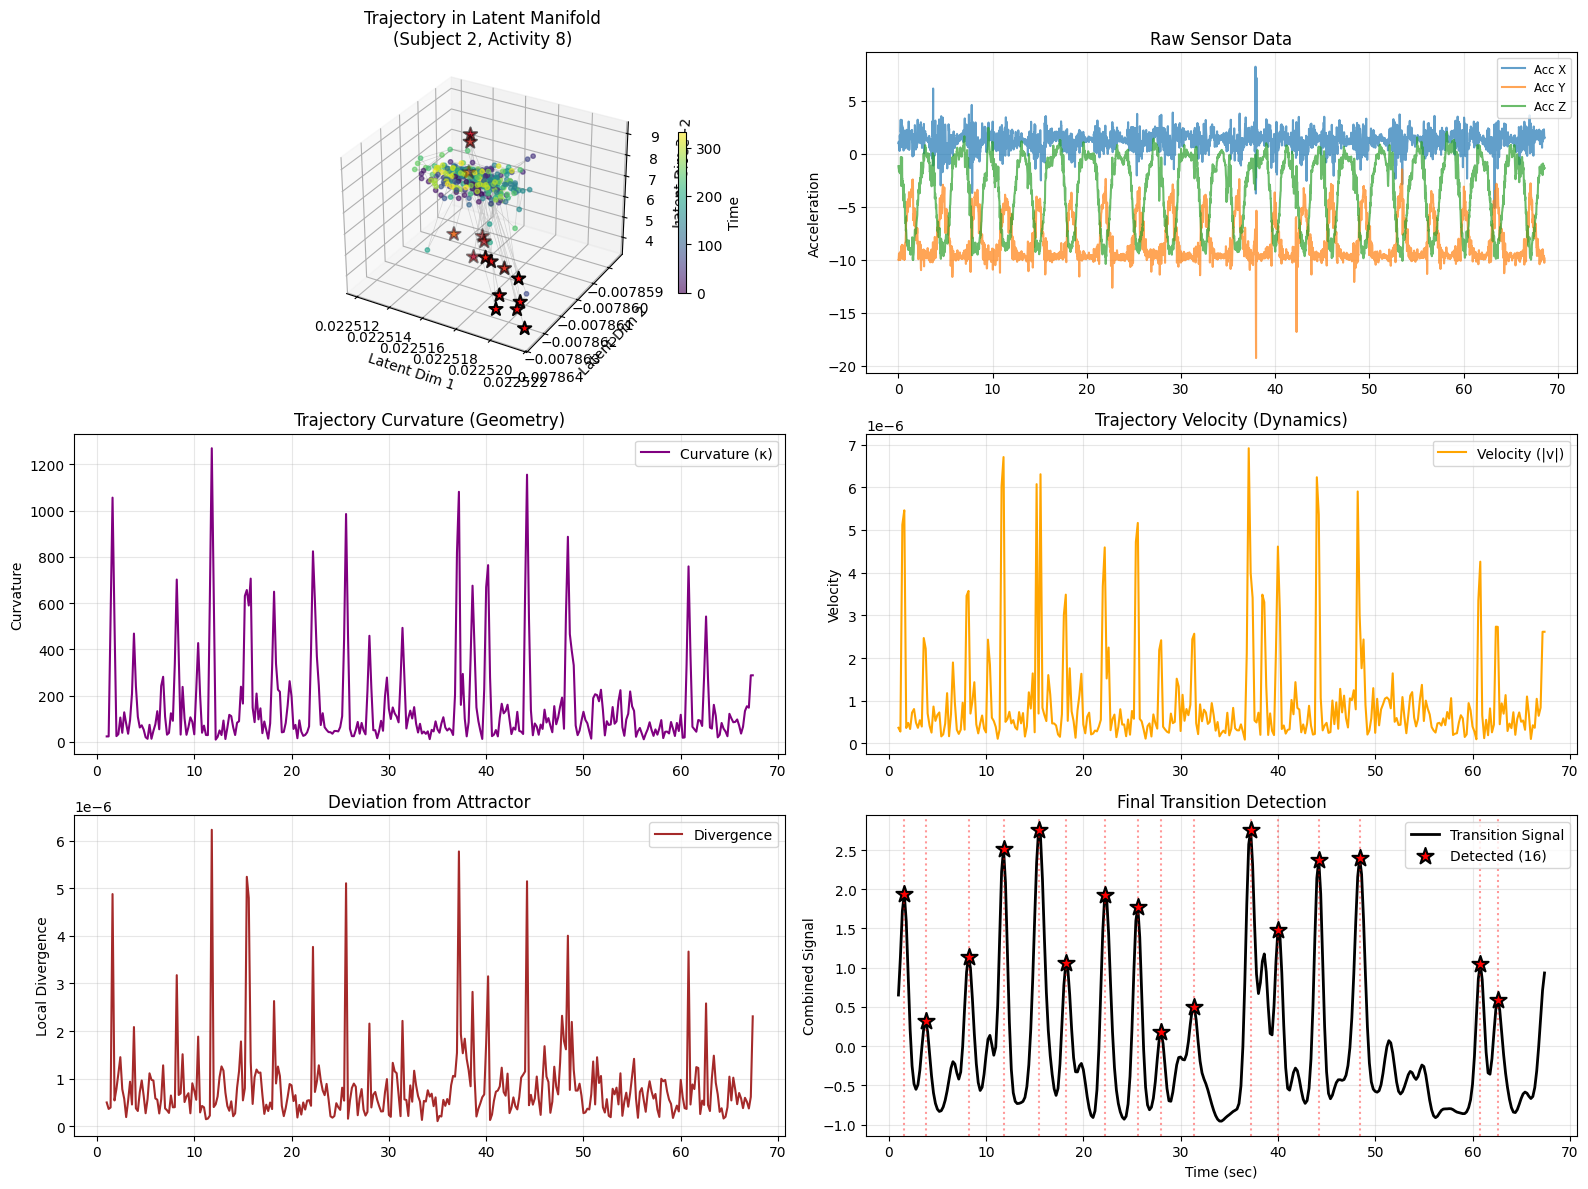

Subject 7 | Activity 4 | Detected Transitions: 11


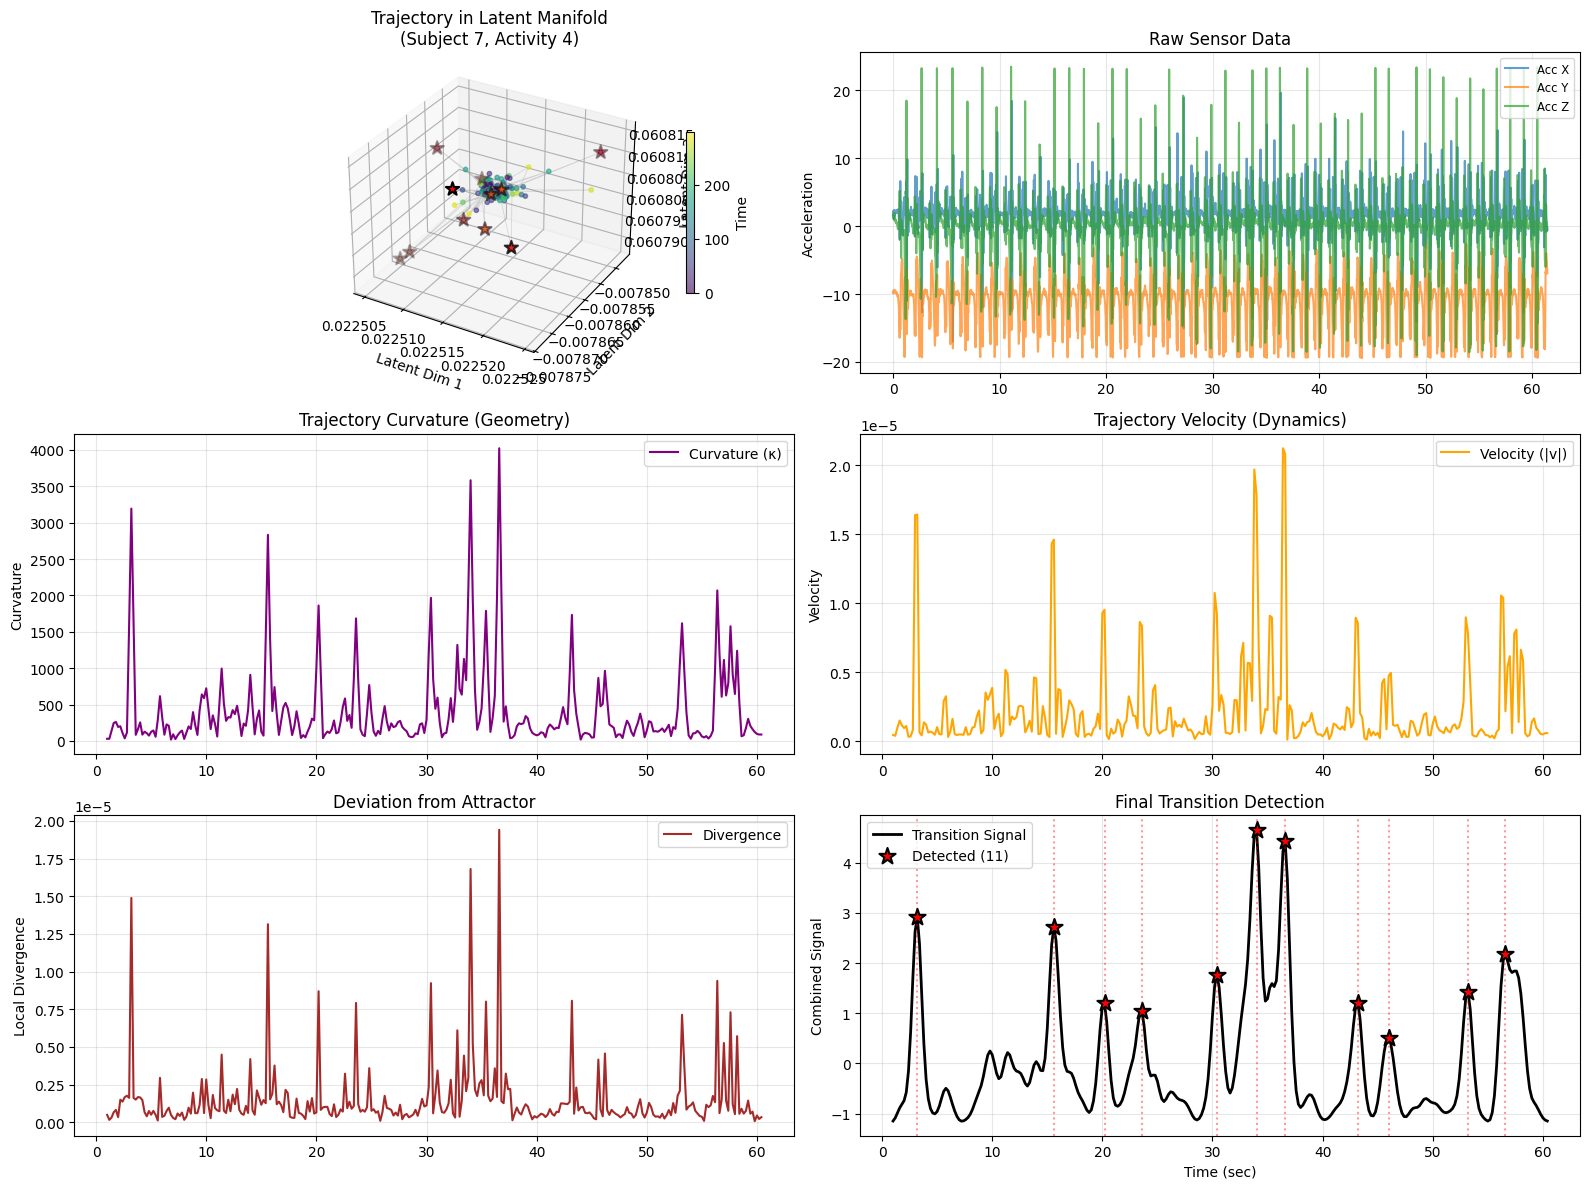

Subject 7 | Activity 6 | Detected Transitions: 1


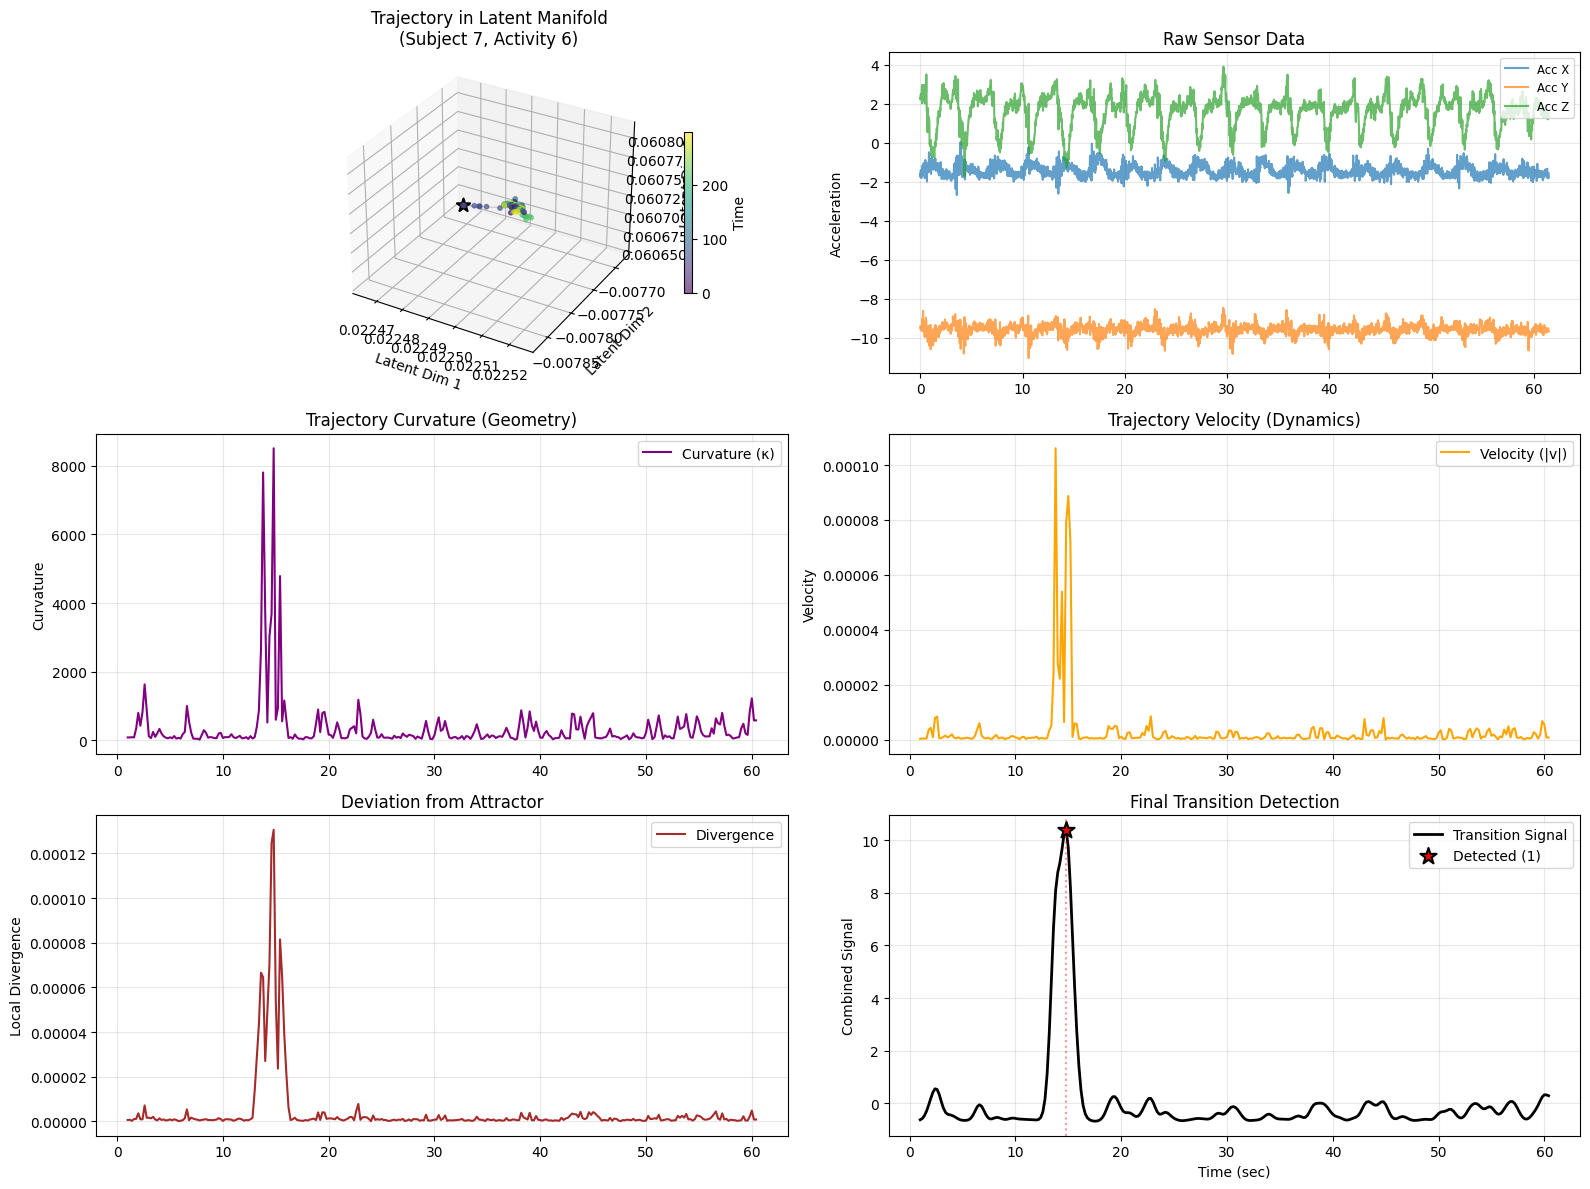

Subject 7 | Activity 7 | Detected Transitions: 8


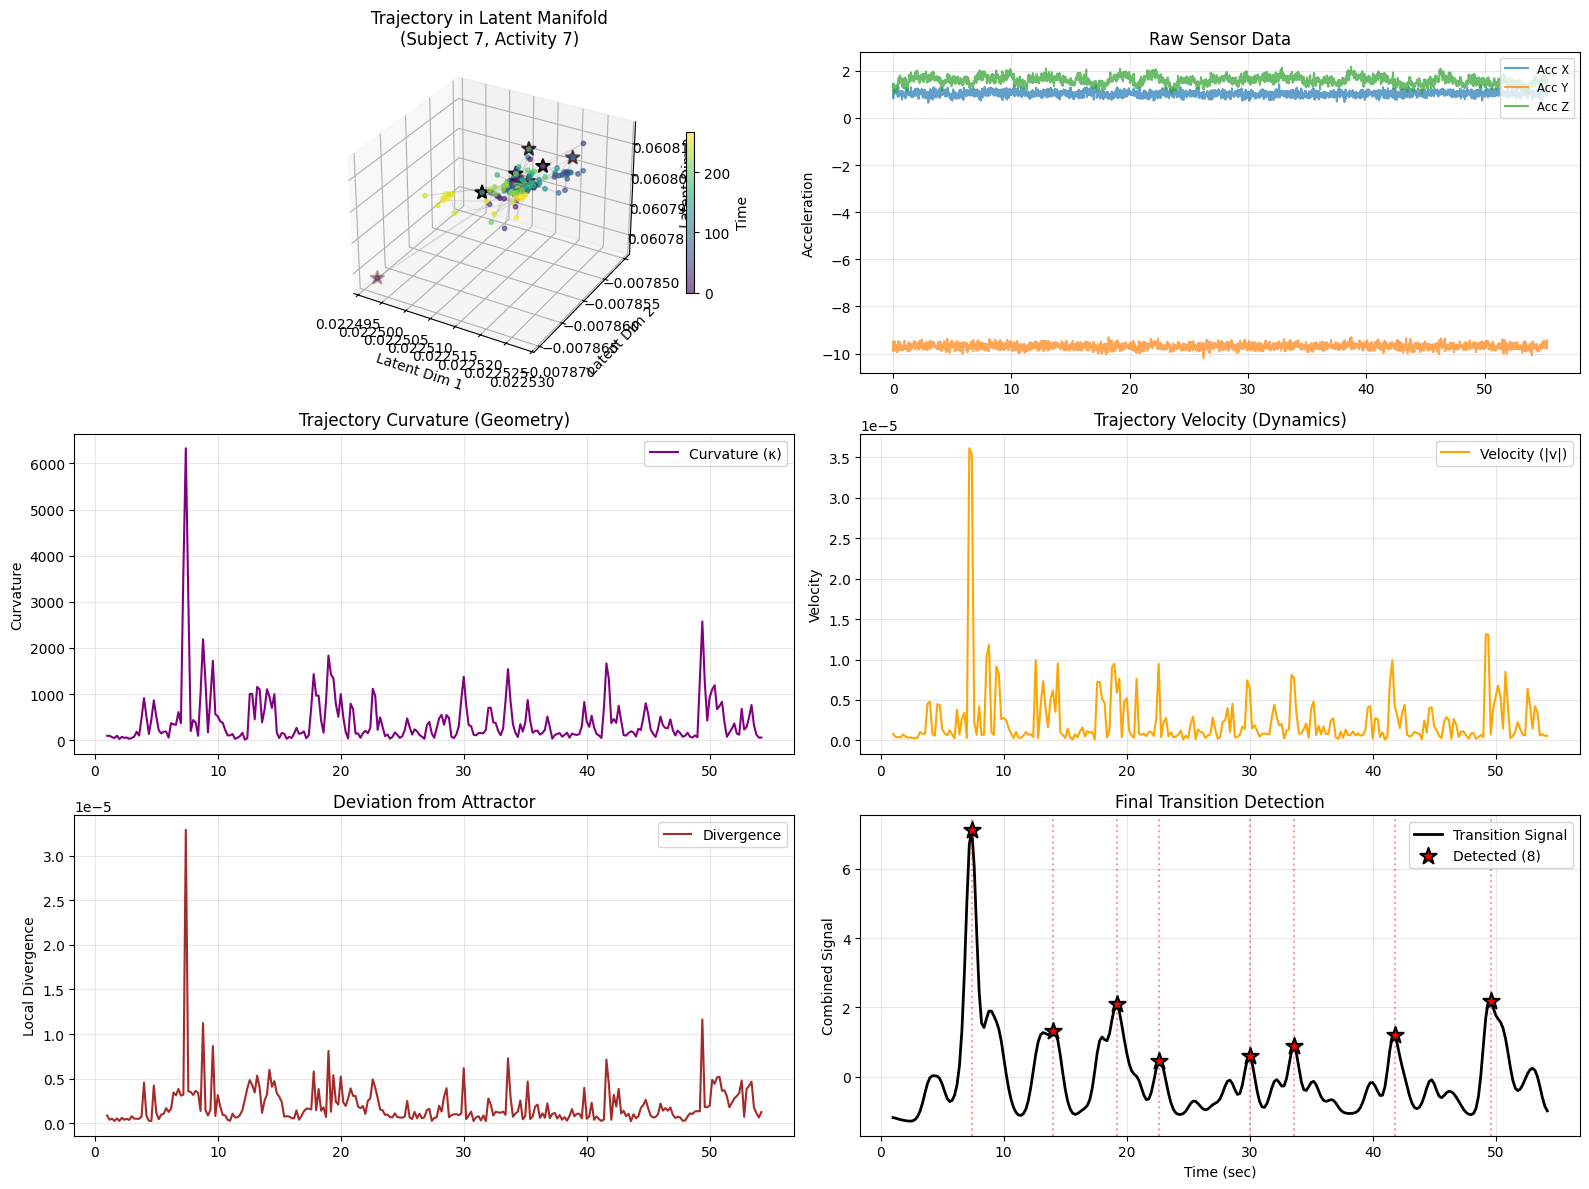

Subject 7 | Activity 8 | Detected Transitions: 11


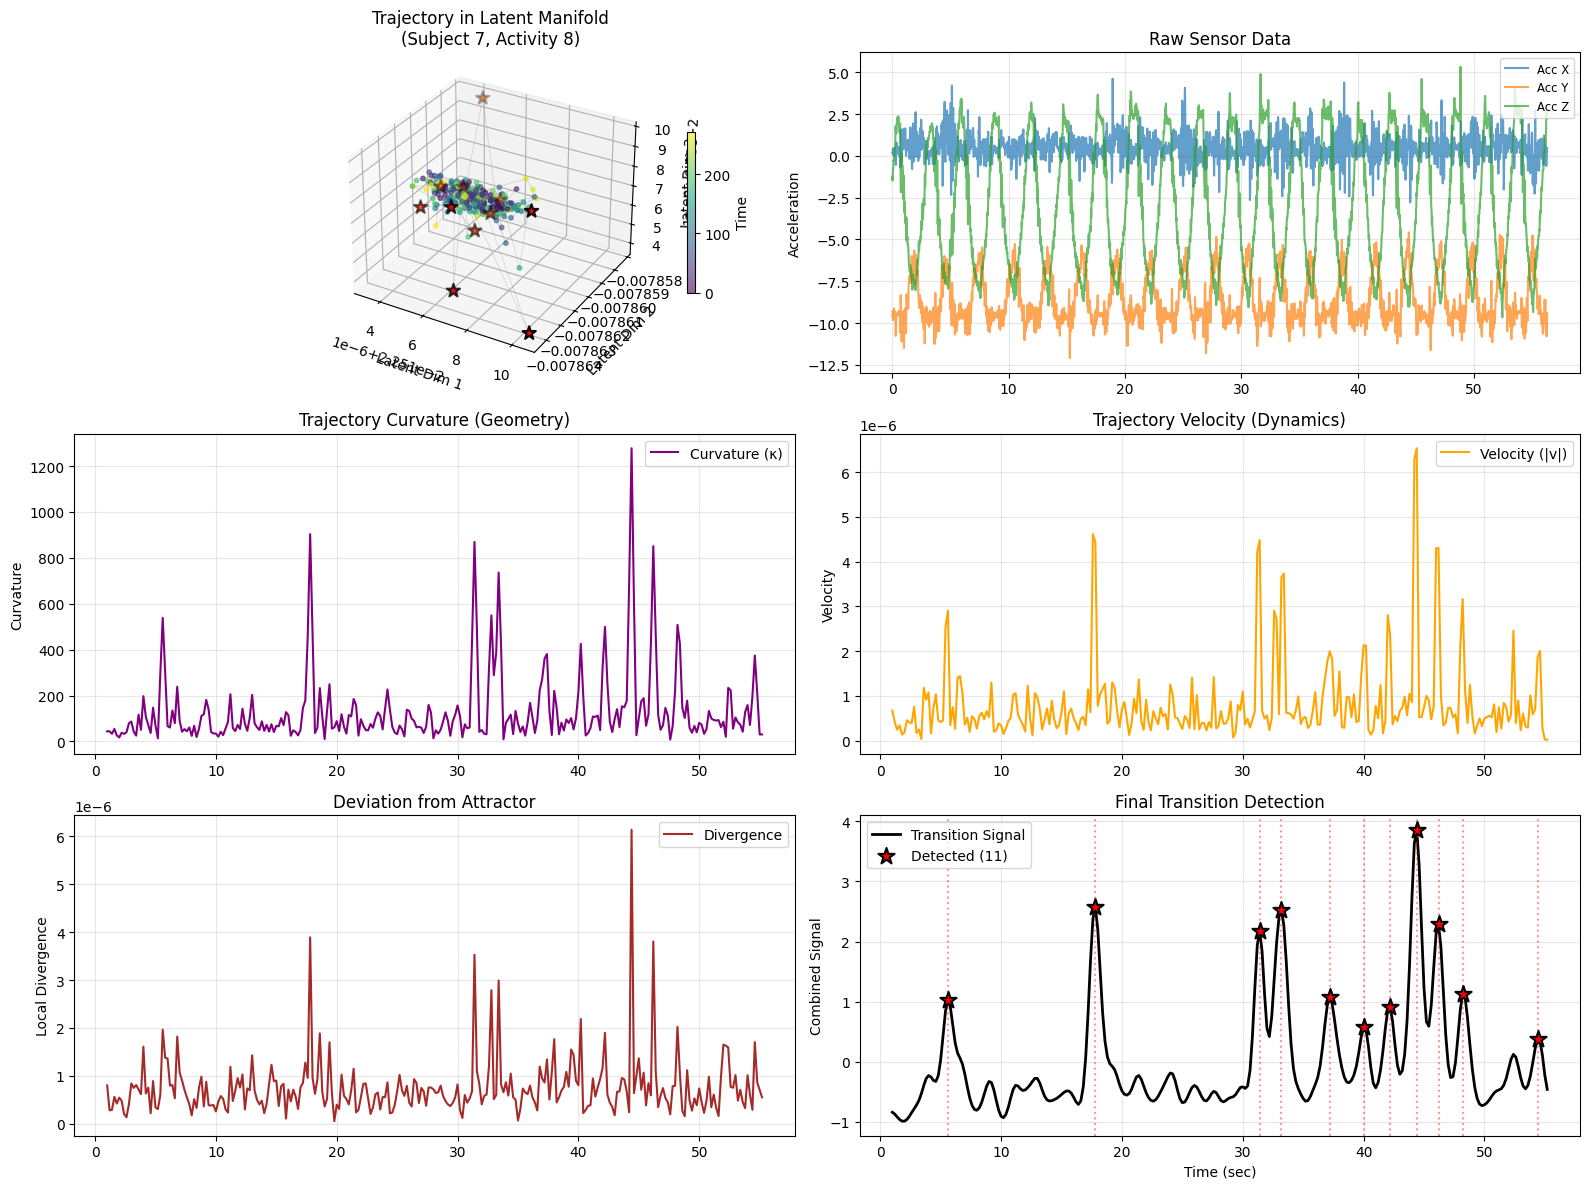


Analysis Complete!


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ==========================================
# 0. Configuration
# ==========================================
CONFIG = {
    'window_size': 100,
    'stride': 50,
    'batch_size': 64,
    'lr': 1e-3,
    'epochs': 30,
    'latent_dim': 3,  # 3D for visualization (can be 5-10 for better performance)
    'hidden_dim': 128,
    'lambda_recon': 1.0,
    'lambda_smooth': 0.1,  # Trajectory smoothness regularization
    'fs': 50,
    'seed': 42,
    'target_activities': [4, 6, 7, 8],
    'train_subjects': ['subject1', 'subject2'],
    'test_subjects': ['subject2', 'subject7'],
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seed(CONFIG['seed'])

# ==========================================
# 1. Manifold Encoder (VAE-style)
# ==========================================
class ManifoldEncoder(nn.Module):
    """
    Maps sensor data to low-dimensional latent manifold
    Uses VAE structure but trained as deterministic AE for stability
    """
    def __init__(self, input_ch=6, hidden_dim=128, latent_dim=3, win_size=100):
        super().__init__()

        # Encoder: Extract temporal features
        self.conv1 = nn.Conv1d(input_ch, hidden_dim, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool = nn.AdaptiveAvgPool1d(1)

        # Latent projection
        self.fc_latent = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        # Decoder: Reconstruct signal
        self.fc_decode = nn.Linear(latent_dim, hidden_dim * 25)
        self.deconv1 = nn.ConvTranspose1d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose1d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.final = nn.Conv1d(hidden_dim, input_ch, kernel_size=3, padding=1)

        self.input_ch = input_ch
        self.win_size = win_size

    def encode(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = self.pool(h).squeeze(-1)
        z = self.fc_latent(h)
        return z

    def decode(self, z):
        h = self.fc_decode(z).view(-1, 128, 25)
        h = F.relu(self.deconv1(h))
        h = F.relu(self.deconv2(h))
        out = self.final(h)
        return out

    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return z, recon

# ==========================================
# 2. Differential Geometry Operations
# ==========================================
def compute_curvature(trajectory):
    """
    Compute curvature of a trajectory in latent space

    Args:
        trajectory: (N, D) tensor of points in D-dimensional space

    Returns:
        curvature: (N-2,) tensor of local curvature values
    """
    if len(trajectory) < 3:
        return torch.zeros(1)

    # Finite difference approximation of derivatives
    # First derivative (velocity)
    v = trajectory[1:-1] - trajectory[:-2]  # (N-2, D)
    v_next = trajectory[2:] - trajectory[1:-1]

    # Second derivative (acceleration)
    a = v_next - v  # (N-2, D)

    # Curvature: κ = |v × a| / |v|^3
    v_norm = torch.norm(v, dim=1, keepdim=True) + 1e-8
    a_norm = torch.norm(a, dim=1, keepdim=True) + 1e-8

    # Simplified curvature (works for any dimension)
    # κ ≈ |a| / |v|^2
    curvature = a_norm.squeeze() / (v_norm.squeeze() ** 2 + 1e-8)

    return curvature

def compute_velocity(trajectory):
    """
    Compute velocity magnitude along trajectory
    """
    if len(trajectory) < 2:
        return torch.zeros(1)

    v = trajectory[1:] - trajectory[:-1]
    v_mag = torch.norm(v, dim=1)
    return v_mag

def compute_trajectory_divergence(trajectory, window=5):
    """
    Compute how much trajectory deviates from its local neighborhood
    Higher values indicate leaving attractor region
    """
    if len(trajectory) < window * 2:
        return torch.zeros(len(trajectory))

    divergence = []
    for i in range(len(trajectory)):
        start = max(0, i - window)
        end = min(len(trajectory), i + window + 1)

        local_points = trajectory[start:end]
        centroid = local_points.mean(dim=0)

        # Distance from local centroid
        div = torch.norm(trajectory[i] - centroid)
        divergence.append(div.item())

    return np.array(divergence)

# ==========================================
# 3. Dataset (from original code)
# ==========================================
class RawSequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32).transpose(0, 1)

def load_and_preprocess(file_path, config):
    """Reuse from original code"""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    df = pd.read_csv(file_path)
    candidate_features = ['alx', 'aly', 'alz', 'glx', 'gly', 'glz']

    if not all(col in df.columns for col in candidate_features):
        print("[Info] Standard columns not found. Trying to detect MHEALTH columns...")
        if 'acc_rw_x' in df.columns:
            print(" -> Using Right Wrist Sensor")
            feature_map = {
                'acc_rw_x': 'alx', 'acc_rw_y': 'aly', 'acc_rw_z': 'alz',
                'gyro_rw_x': 'glx', 'gyro_rw_y': 'gly', 'gyro_rw_z': 'glz'
            }
        elif 'acc_la_x' in df.columns:
            print(" -> Using Left Ankle Sensor")
            feature_map = {
                'acc_la_x': 'alx', 'acc_la_y': 'aly', 'acc_la_z': 'alz',
                'gyro_la_x': 'glx', 'gyro_la_y': 'gly', 'gyro_la_z': 'glz'
            }
        else:
            cols = df.columns[:6]
            feature_map = {cols[i]: candidate_features[i] for i in range(6)}
        df.rename(columns=feature_map, inplace=True)

    if 'subject' not in df.columns: df['subject'] = 'subject1'
    if 'Activity' not in df.columns:
        if 'Label' in df.columns: df.rename(columns={'Label': 'Activity'}, inplace=True)
        else: df['Activity'] = 0

    df['subject_id'] = df['subject'].apply(lambda x: int(str(x).replace('subject', '')) if isinstance(x, str) else int(x))

    train_ids = [int(str(s).replace('subject', '')) for s in config['train_subjects']]
    test_ids = [int(str(s).replace('subject', '')) for s in config['test_subjects']]

    df_train = df[df['subject_id'].isin(train_ids)].copy()
    df_test = df[df['subject_id'].isin(test_ids)].copy()

    return df_train, df_test, candidate_features

def create_windows(df, features, config):
    """Reuse from original code"""
    windows = []
    for sub in df['subject_id'].unique():
        sub_df = df[df['subject_id'] == sub][features].values
        mean = np.mean(sub_df, axis=0)
        std = np.std(sub_df, axis=0) + 1e-6
        norm_data = (sub_df - mean) / std

        for i in range(0, len(norm_data) - config['window_size'], config['stride']):
            windows.append(norm_data[i : i + config['window_size']])

    return np.array(windows)

# ==========================================
# 4. Training Loop
# ==========================================
def train(model, loader, config):
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    model.train()

    print("\n[Training Manifold Encoder]")
    for epoch in range(config['epochs']):
        total_loss = 0
        total_recon = 0
        total_smooth = 0

        for x in loader:
            x = x.to(DEVICE)
            z, recon = model(x)

            # Reconstruction loss
            loss_recon = F.mse_loss(recon, x)

            # Trajectory smoothness regularization
            # Encourage smooth manifold structure
            if len(z) > 1:
                z_diff = z[1:] - z[:-1]
                loss_smooth = torch.mean(torch.norm(z_diff, dim=1))
            else:
                loss_smooth = torch.tensor(0.0)

            loss = config['lambda_recon'] * loss_recon + \
                   config['lambda_smooth'] * loss_smooth

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon += loss_recon.item()
            total_smooth += loss_smooth.item()

        if (epoch+1) % 5 == 0:
            avg_loss = total_loss / len(loader)
            avg_recon = total_recon / len(loader)
            avg_smooth = total_smooth / len(loader)
            print(f"Epoch {epoch+1}/{config['epochs']} | Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | Smooth: {avg_smooth:.4f}")

    return model

# ==========================================
# 5. Trajectory Analysis & Transition Detection
# ==========================================
def detect_transitions_via_manifold(model, df_test, features, config):
    """
    Main detection pipeline using manifold geometry
    """
    model.eval()

    for sub in df_test['subject_id'].unique():
        sub_data = df_test[df_test['subject_id'] == sub]

        for act in config['target_activities']:
            act_data = sub_data[sub_data['Activity'] == act]

            if len(act_data) < config['window_size'] * 3:
                continue

            # Prepare data
            raw_vals = act_data[features].values
            mean = np.mean(raw_vals, axis=0)
            std = np.std(raw_vals, axis=0) + 1e-6
            norm_vals = (raw_vals - mean) / std

            # Extract trajectory in latent space
            latent_points = []
            step = 10

            with torch.no_grad():
                for i in range(0, len(norm_vals) - config['window_size'], step):
                    segment = norm_vals[i : i + config['window_size']]
                    x_in = torch.tensor(segment, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(DEVICE)
                    z, _ = model(x_in)
                    latent_points.append(z.cpu().numpy())

            latent_points = np.concatenate(latent_points, axis=0)  # (N, latent_dim)
            latent_tensor = torch.tensor(latent_points, dtype=torch.float32)

            # Compute geometric features
            curvature = compute_curvature(latent_tensor).numpy()
            velocity = compute_velocity(latent_tensor).numpy()
            divergence = compute_trajectory_divergence(latent_tensor, window=5)

            # Pad curvature to match length
            curvature_padded = np.pad(curvature, (1, 1), mode='edge')
            velocity_padded = np.pad(velocity, (0, 1), mode='edge')

            # Combined transition signal
            # High curvature + high velocity + high divergence = transition
            curvature_norm = (curvature_padded - np.mean(curvature_padded)) / (np.std(curvature_padded) + 1e-6)
            velocity_norm = (velocity_padded - np.mean(velocity_padded)) / (np.std(velocity_padded) + 1e-6)
            divergence_norm = (divergence - np.mean(divergence)) / (np.std(divergence) + 1e-6)

            transition_signal = curvature_norm + velocity_norm + 0.5 * divergence_norm

            # Smoothing
            smoothed_signal = gaussian_filter1d(transition_signal, sigma=2.0)

            # Peak detection
            prominence = 0.8 * np.std(smoothed_signal)
            height_thresh = np.percentile(smoothed_signal, 60)
            min_dist = int((0.8 * config['fs']) / step)

            peaks, properties = find_peaks(smoothed_signal,
                                          height=height_thresh,
                                          prominence=prominence,
                                          distance=max(min_dist, 1))

            print(f"Subject {sub} | Activity {act} | Detected Transitions: {len(peaks)}")

            # Visualization
            if len(peaks) > 0:
                visualize_manifold_analysis(
                    raw_vals, latent_points,
                    curvature_padded, velocity_padded, divergence,
                    smoothed_signal, peaks,
                    config, step, sub, act
                )

# ==========================================
# 6. Visualization
# ==========================================
def visualize_manifold_analysis(raw_vals, latent_points, curvature, velocity,
                                divergence, transition_signal, peaks,
                                config, step, sub, act):
    """
    Comprehensive visualization of manifold-based transition detection
    """
    time_axis_raw = np.arange(len(raw_vals)) / config['fs']
    time_axis_latent = (np.arange(len(latent_points)) * step + config['window_size']//2) / config['fs']

    fig = plt.figure(figsize=(16, 12))

    # 1. 3D Trajectory in Latent Space
    ax1 = fig.add_subplot(3, 2, 1, projection='3d')
    if latent_points.shape[1] >= 3:
        scatter = ax1.scatter(latent_points[:, 0], latent_points[:, 1], latent_points[:, 2],
                            c=np.arange(len(latent_points)), cmap='viridis', s=10, alpha=0.6)
        ax1.plot(latent_points[:, 0], latent_points[:, 1], latent_points[:, 2],
                'gray', alpha=0.3, linewidth=0.5)

        # Highlight transition points
        if len(peaks) > 0:
            ax1.scatter(latent_points[peaks, 0], latent_points[peaks, 1], latent_points[peaks, 2],
                       c='red', s=100, marker='*', edgecolors='black', linewidths=1.5)

        ax1.set_xlabel('Latent Dim 1')
        ax1.set_ylabel('Latent Dim 2')
        ax1.set_zlabel('Latent Dim 3')
        ax1.set_title(f'Trajectory in Latent Manifold\n(Subject {sub}, Activity {act})')
        plt.colorbar(scatter, ax=ax1, label='Time', shrink=0.5)

    # 2. Raw Accelerometer
    ax2 = fig.add_subplot(3, 2, 2)
    ax2.plot(time_axis_raw, raw_vals[:, 0], label='Acc X', alpha=0.7)
    ax2.plot(time_axis_raw, raw_vals[:, 1], label='Acc Y', alpha=0.7)
    ax2.plot(time_axis_raw, raw_vals[:, 2], label='Acc Z', alpha=0.7)
    ax2.set_ylabel('Acceleration')
    ax2.set_title('Raw Sensor Data')
    ax2.legend(loc='upper right', fontsize='small')
    ax2.grid(True, alpha=0.3)

    # 3. Curvature
    ax3 = fig.add_subplot(3, 2, 3)
    ax3.plot(time_axis_latent, curvature, color='purple', linewidth=1.5, label='Curvature (κ)')
    ax3.set_ylabel('Curvature')
    ax3.set_title('Trajectory Curvature (Geometry)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Velocity
    ax4 = fig.add_subplot(3, 2, 4)
    ax4.plot(time_axis_latent, velocity, color='orange', linewidth=1.5, label='Velocity (|v|)')
    ax4.set_ylabel('Velocity')
    ax4.set_title('Trajectory Velocity (Dynamics)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Divergence
    ax5 = fig.add_subplot(3, 2, 5)
    ax5.plot(time_axis_latent, divergence, color='brown', linewidth=1.5, label='Divergence')
    ax5.set_ylabel('Local Divergence')
    ax5.set_title('Deviation from Attractor')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Combined Transition Signal
    ax6 = fig.add_subplot(3, 2, 6)
    ax6.plot(time_axis_latent, transition_signal, color='black', linewidth=2, label='Transition Signal')
    ax6.scatter(time_axis_latent[peaks], transition_signal[peaks],
               c='red', s=150, marker='*', zorder=5, label=f'Detected ({len(peaks)})',
               edgecolors='black', linewidths=1.5)

    for p_t in time_axis_latent[peaks]:
        ax6.axvline(x=p_t, color='red', linestyle=':', alpha=0.4)

    ax6.set_xlabel('Time (sec)')
    ax6.set_ylabel('Combined Signal')
    ax6.set_title('Final Transition Detection')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==========================================
# 7. Main Execution
# ==========================================
def main():
    file_path = '/content/drive/MyDrive/Colab Notebooks/MHEALTH/mhealth_raw_data.csv'

    print("="*60)
    print("Latent Manifold Curvature for Transition Detection")
    print("="*60)

    # 1. Data Loading
    print("\n[Step 1] Loading Data...")
    try:
        df_train, df_test, feature_cols = load_and_preprocess(file_path, CONFIG)
    except FileNotFoundError:
        print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")
        return

    print(f"Features: {feature_cols}")
    print(f"Train samples: {len(df_train)} | Test samples: {len(df_test)}")

    # 2. Prepare Training Data
    print("\n[Step 2] Creating Training Windows...")
    train_windows = create_windows(df_train, feature_cols, CONFIG)
    print(f"Train Windows: {train_windows.shape}")

    train_dataset = RawSequenceDataset(train_windows)
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)

    # 3. Model Training
    print("\n[Step 3] Training Manifold Encoder...")
    model = ManifoldEncoder(
        input_ch=6,
        hidden_dim=CONFIG['hidden_dim'],
        latent_dim=CONFIG['latent_dim'],
        win_size=CONFIG['window_size']
    ).to(DEVICE)

    model = train(model, train_loader, CONFIG)

    # 4. Transition Detection via Manifold Analysis
    print("\n[Step 4] Detecting Transitions via Manifold Geometry...")
    detect_transitions_via_manifold(model, df_test, feature_cols, CONFIG)

    print("\n" + "="*60)
    print("Analysis Complete!")
    print("="*60)

if __name__ == '__main__':
    main()